In [62]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

%matplotlib inline

In [2]:
def convert_to_float(value):
    """
    Transforms argument value to float;
    Replaces the comma in a string variable with a dot and rounds the value to two decimal places;
    
    Parameters
    --------
    value: float
    
    Returns
    --------
    float
    
    """
    value = float(str(value).replace(",", "."))
    value = round(value, 2)
    return value

#######################################################################################################################

In [7]:
# Загрузка датафрейма из CSV файла;
cleared = pd.read_csv('../output/cleared.csv')

cleared = cleared[cleared['warp_dens'] < 40]

# Приведение типов колонок датафрейма к значению с плавающей запятой;
cleared['warp_a'] = cleared.warp_a.apply(convert_to_float)
cleared['warp_b'] = cleared.warp_b.apply(convert_to_float)
cleared['weft_a'] = cleared.weft_a.apply(convert_to_float)
cleared['weft_b'] = cleared.weft_b.apply(convert_to_float)
cleared['warp_mean'] = cleared.warp_mean.apply(convert_to_float)
cleared['weft_mean'] = cleared.weft_mean.apply(convert_to_float)
cleared['warp_dens'] = cleared.warp_dens.apply(convert_to_float)
cleared['weft_dens'] = cleared.weft_dens.apply(convert_to_float)

# Вычисление "усредненных" толщин нитей;
cleared['warp_nominal'] = round((cleared['warp_a'] + cleared['warp_b']) / 2, 2)
cleared['weft_nominal'] = round((cleared['weft_a'] + cleared['weft_b']) / 2, 2)

cleared['dens_coef'] = round(cleared['warp_dens'] / cleared['weft_dens'], 2)
cleared['thick_coef'] = round(cleared['warp_nominal'] / cleared['weft_nominal'], 2)

In [32]:
# датафрейм, очищенный от выбросов - только необходимые признаки;
cleared = cleared[['warp_mean', 'weft_mean', 'warp_dens', 'weft_dens']]
cleared.head()

,warp_mean,weft_mean,warp_dens,weft_dens
0,0.75,0.75,13.0,8.0
1,0.40,0.70,16.0,10.0
2,0.50,0.15,18.0,6.0
3,0.35,0.40,30.0,9.0
4,0.50,0.55,24.0,10.0


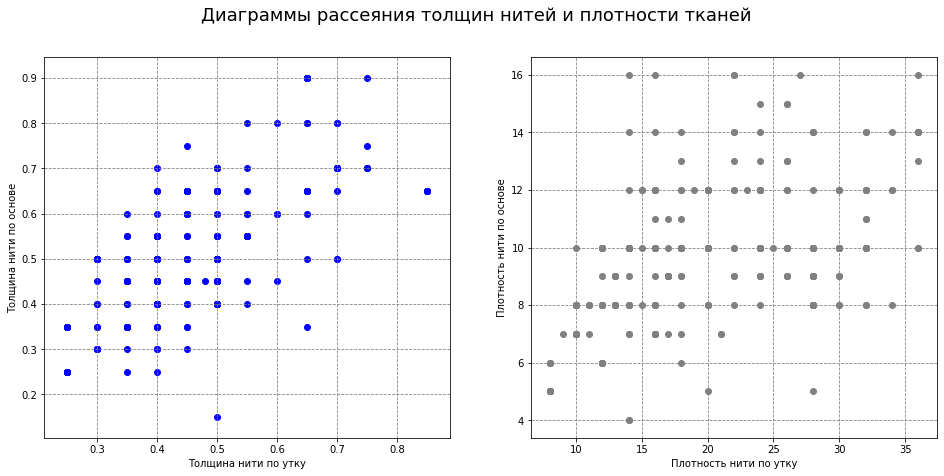

In [170]:
fig, ax = plt.subplots(1, 2, figsize=(16, 7))

fig.suptitle('Диаграммы рассеяния толщин нитей и плотности тканей', fontsize=18)
ax[0].scatter(cleared['warp_mean'], cleared['weft_mean'], color='blue')
ax[0].set_ylabel('Толщина нити по основе')
ax[0].set_xlabel('Толщина нити по утку')
ax[0].grid(color='gray', linestyle='--')

ax[1].scatter(cleared['warp_dens'], cleared['weft_dens'], color='gray')
ax[1].set_ylabel('Плотность нити по основе')
ax[1].set_xlabel('Плотность нити по утку')
ax[1].grid(color='gray', linestyle='--')

plt.show()

In [34]:
scaler = StandardScaler()

In [40]:
scaler.fit(cleared)
cleared_stand = scaler.transform(cleared)

In [42]:
print(cleared_stand)

[[ 2.2746174   1.73282072 -0.93380606 -0.70862255]
 [-0.56197478  1.37444189 -0.53877137  0.11810376]
 [ 0.24848013 -2.56772525 -0.27541491 -1.53534887]
 ...
 [ 0.24848013 -0.7758311   0.25129802  1.77155638]
 [ 0.24848013 -0.7758311   0.25129802  1.77155638]
 [ 0.24848013 -0.7758311   1.0413674   1.77155638]]


In [13]:
pca = PCA(n_components=2, random_state=1)

In [43]:
pca.fit(cleared_stand)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=1,
    svd_solver='auto', tol=0.0, whiten=False)

In [47]:
X = pca.transform(cleared_stand)

In [222]:
cleared['PC1'] = X[:, 0]
cleared['PC2'] = X[:, 1]

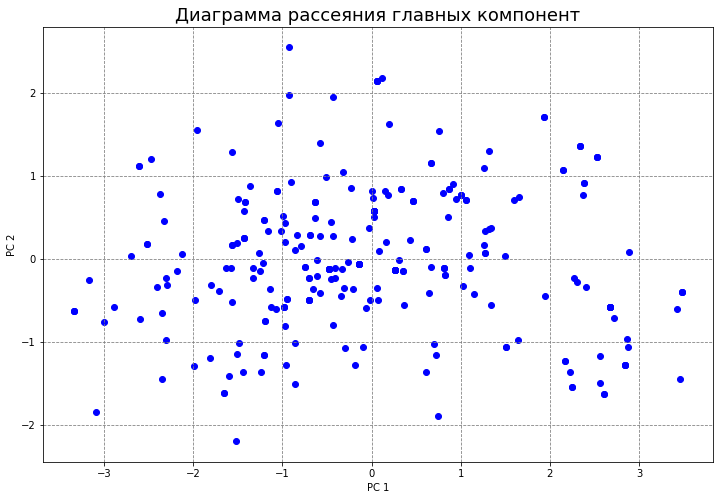

In [223]:
fig, ax = plt.subplots(figsize=(12, 8))

ax.scatter(X[:, 0], X[:, 1], color='blue')
ax.set_title('Диаграмма рассеяния главных компонент', fontsize=18)
ax.set_ylabel('PC 2')
ax.set_xlabel('PC 1')
ax.grid(color='gray', linestyle='--')

plt.show()

In [224]:
# "модель" кластеризации - предполагаемое/ожидаемое число кластеров, начальное "псевдослучайное" состояние;
kmeans = KMeans(n_clusters=3, random_state=2)

In [225]:
kmeans.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=2, tol=0.0001, verbose=0)

In [226]:
cleared['labels'] = kmeans.labels_

In [227]:
cluster_1 = cleared[cleared.labels == 0]
cluster_2 = cleared[cleared.labels == 1]
cluster_3 = cleared[cleared.labels == 2]

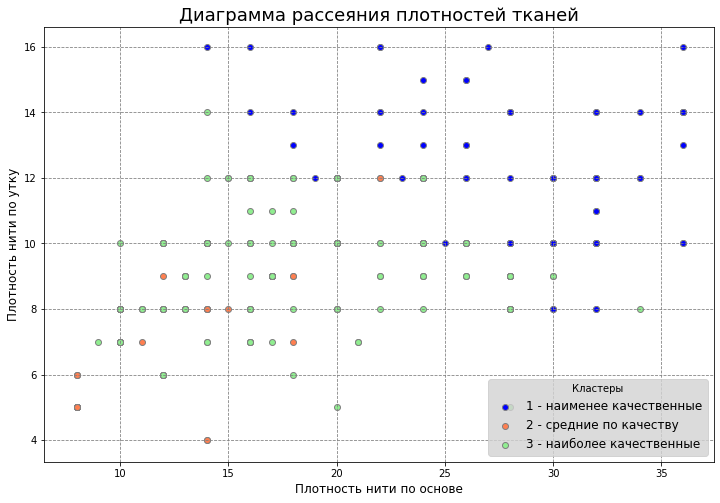

In [228]:
fig, ax = plt.subplots(figsize=(12, 8))

ax.scatter(cluster_1.warp_dens, cluster_1.weft_dens, color='blue', edgecolor='gray', label='1 - наименее качественные')
ax.scatter(cluster_2.warp_dens, cluster_2.weft_dens, color='coral', edgecolor='gray', label='2 - средние по качеству')
ax.scatter(cluster_3.warp_dens, cluster_3.weft_dens, color='lightgreen', edgecolor='gray', label='3 - наиболее качественные')

ax.set_title('Диаграмма рассеяния плотностей тканей', fontsize=18)
ax.set_xlabel('Плотность нити по основе', fontsize=12)
ax.set_ylabel('Плотность нити по утку', fontsize=12)

ax.legend(fontsize=12, facecolor='lightgray', title='Кластеры')
ax.grid(color='gray', linestyle='--')

plt.show()

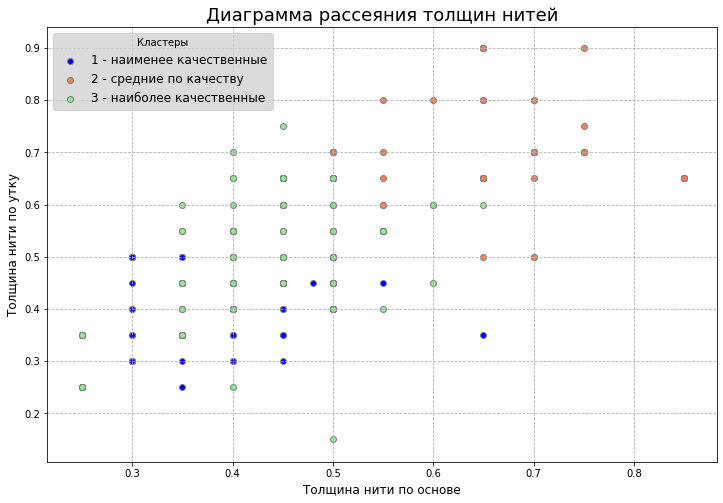

In [229]:
fig, ax = plt.subplots(figsize=(12, 8))

ax.scatter(cluster_1.warp_mean, cluster_1.weft_mean, color='blue', edgecolor='gray', label='1 - наименее качественные')
ax.scatter(cluster_2.warp_mean, cluster_2.weft_mean, color='coral', edgecolor='gray', label='2 - средние по качеству')
ax.scatter(cluster_3.warp_mean, cluster_3.weft_mean, color='lightgreen', edgecolor='gray', label='3 - наиболее качественные')

ax.set_title('Диаграмма рассеяния толщин нитей', fontsize=18)
ax.set_xlabel('Толщина нити по основе', fontsize=12)
ax.set_ylabel('Толщина нити по утку', fontsize=12)

ax.legend(fontsize=12, facecolor='lightgray', title='Кластеры')
ax.grid(linestyle='--')

plt.show()

In [230]:
print(len(cluster_1))
print(len(cluster_2))
print(len(cluster_3))

97
59
117


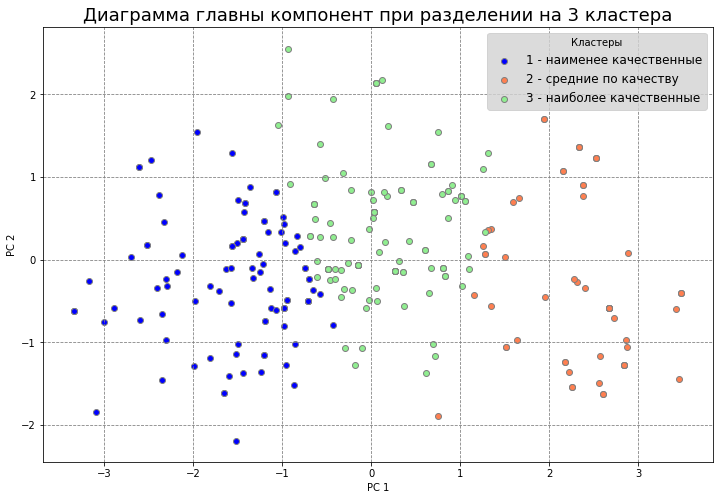

In [255]:
fig, ax = plt.subplots(figsize=(12, 8))

ax.scatter(cluster_1.PC1, cluster_1.PC2, color='blue', edgecolor='gray', label='1 - наименее качественные')
ax.scatter(cluster_2.PC1, cluster_2.PC2, color='coral', edgecolor='gray', label='2 - средние по качеству')
ax.scatter(cluster_3.PC1, cluster_3.PC2, color='lightgreen', edgecolor='gray', label='3 - наиболее качественные')

ax.set_title('Диаграмма главны компонент при разделении на 3 кластера', fontsize=18)
ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')

ax.legend(fontsize=12, facecolor='lightgray', title='Кластеры')
ax.grid(color="gray", linestyle='--')

plt.show()

## Кластеризация на 2 кластера

In [231]:
kmeans_2 = KMeans(n_clusters=2, random_state=2)

In [232]:
kmeans_2.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=2, tol=0.0001, verbose=0)

In [233]:
cleared['labels_2'] = kmeans_2.labels_

In [234]:
cluster_2_1 = cleared[cleared.labels_2 == 0]
cluster_2_2 = cleared[cleared.labels_2 == 1]

In [235]:
print(len(cluster_2_1))
print(len(cluster_2_2))

178
95


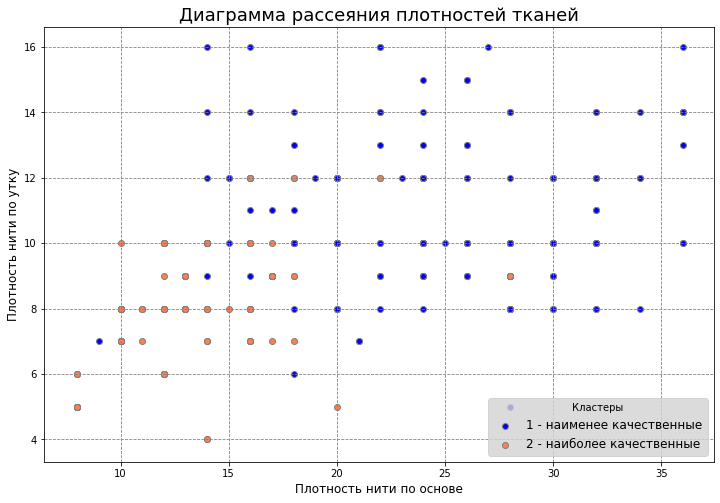

In [236]:
fig, ax = plt.subplots(figsize=(12, 8))

ax.scatter(cluster_2_1.warp_dens, cluster_2_1.weft_dens, color='blue', edgecolor='gray', label='1 - наименее качественные')
ax.scatter(cluster_2_2.warp_dens, cluster_2_2.weft_dens, color='coral', edgecolor='gray', label='2 - наиболее качественные')

ax.set_title('Диаграмма рассеяния плотностей тканей', fontsize=18)
ax.set_xlabel('Плотность нити по основе', fontsize=12)
ax.set_ylabel('Плотность нити по утку', fontsize=12)

ax.legend(fontsize=12, facecolor='lightgray', title='Кластеры')
ax.grid(color='gray', linestyle='--')


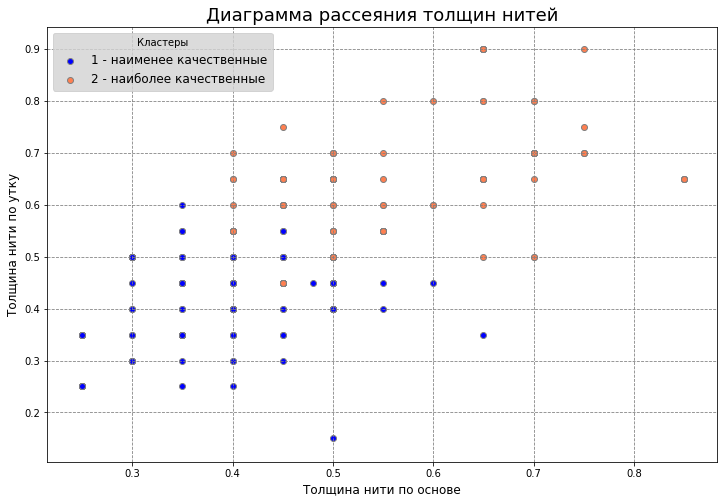

In [237]:
fig, ax = plt.subplots(figsize=(12, 8))

ax.scatter(cluster_2_1.warp_mean, cluster_2_1.weft_mean, color='blue', edgecolor='gray', label='1 - наименее качественные')
ax.scatter(cluster_2_2.warp_mean, cluster_2_2.weft_mean, color='coral', edgecolor='gray', label='2 - наиболее качественные')

ax.set_title('Диаграмма рассеяния толщин нитей', fontsize=18)
ax.set_xlabel('Толщина нити по основе', fontsize=12)
ax.set_ylabel('Толщина нити по утку', fontsize=12)

ax.legend(fontsize=12, facecolor='lightgray', title='Кластеры')
ax.grid(color='gray', linestyle='--')


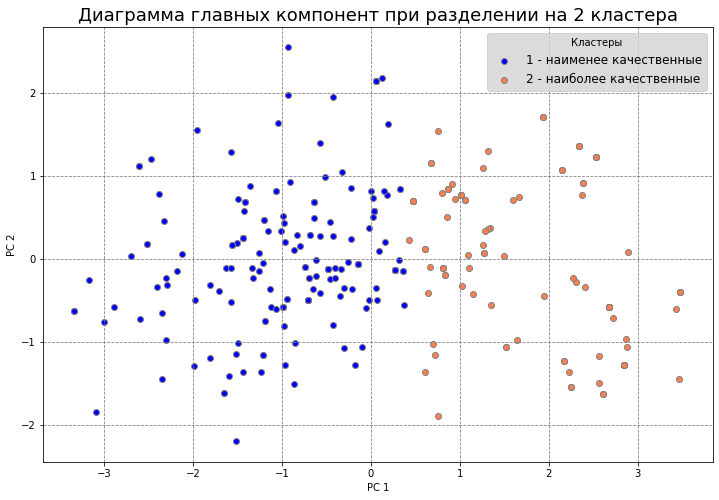

In [245]:
fig, ax = plt.subplots(figsize=(12, 8))

ax.scatter(cluster_2_1.PC1, cluster_2_1.PC2, color="blue", edgecolor="gray", label="1 - наименее качественные")
ax.scatter(cluster_2_2.PC1, cluster_2_2.PC2, color="coral", edgecolor="gray", label="2 - наиболее качественные")

ax.set_title('Диаграмма главных компонент при разделении на 2 кластера', fontsize=18)
ax.set_xlabel("PC 1")
ax.set_ylabel("PC 2")

ax.legend(fontsize=12, facecolor="lightgray", title="Кластеры")
ax.grid(color="gray", linestyle="--")

plt.show()